In [1]:
%pip install -q rank_bm25 kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 21.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
import json
import requests
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap
from typing import List, Dict, Any, Tuple, Union, Set, Optional, Callable, Collection, AbstractSet, Literal
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from abc import ABC, abstractmethod
from attr import dataclass
import logging
import time
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Suppress progress bar output from sentence_transformers
logging.getLogger("sentence_transformers").setLevel(logging.WARNING)

# Create directories for data and results
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)

# Set plot style for scientific visualizations
plt.style.use('seaborn-v0_8-whitegrid')

# Check for GPU availability
try:
    import torch
    GPU_AVAILABLE = torch.cuda.is_available()
    if GPU_AVAILABLE:
        print(f"GPU is available: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version: {torch.version.cuda}")
    else:
        print("GPU is not available. Using CPU.")
except ImportError:
    GPU_AVAILABLE = False
    print("PyTorch not installed. Using CPU.")

# Base URL for raw GitHub content
BASE_URL = "https://raw.githubusercontent.com/brandonstarxel/chunking_evaluation/main/chunking_evaluation/evaluation_framework/general_evaluation_data"

# Available datasets
DATASETS = ["Chatlogs", "State of the Union", "Wikitext"]

GPU is available: Tesla P100-PCIE-16GB
CUDA Version: 12.1


In [4]:
def download_file(url, save_path):
    """
    Download a file from a URL and save it to the specified path.
    
    Args:
        url: URL to download from.
        save_path: Path to save the downloaded file.
    
    Returns:
        True if download was successful, False otherwise.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors
        
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # Save the file
        with open(save_path, 'wb') as f:
            f.write(response.content)
            
        print(f"Downloaded: {save_path}")
        return True
    
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return False

def download_dataset(dataset_name, output_dir):
    """
    Download a dataset from the chunking_evaluation repository.
    
    Args:
        dataset_name: Name of the dataset to download.
        output_dir: Directory to save the dataset.
    
    Returns:
        Tuple of (corpus_path, questions_path) if successful, (None, None) otherwise.
    """
    if dataset_name not in DATASETS:
        print(f"Invalid dataset name. Choose from: {', '.join(DATASETS)}")
        return None, None
    
    # Create dataset directory
    dataset_dir = os.path.join(output_dir, dataset_name.replace(" ", "_"))
    corpus_dir = os.path.join(dataset_dir, "corpora")
    os.makedirs(corpus_dir, exist_ok=True)
    
    # Download questions CSV
    questions_url = f"{BASE_URL}/questions_df.csv"
    questions_path = os.path.join(dataset_dir, "questions_df.csv")
    if not download_file(questions_url, questions_path):
        return None, None
    
    # Map dataset names to their corresponding markdown files
    dataset_files = {
        "Chatlogs": "chatlogs.md",
        "State of the Union": "state_of_the_union.md",
        "Wikitext": "wikitexts.md"
    }
    
    # Download all corpus files
    for ds_name, filename in dataset_files.items():
        corpus_url = f"{BASE_URL}/corpora/{filename}"
        corpus_path = os.path.join(corpus_dir, filename)
        download_file(corpus_url, corpus_path)
    
    return corpus_dir, questions_path

In [5]:
def load_dataset(corpus_path: str, questions_path: str, dataset_name: str) -> Tuple[Dict[str, str], pd.DataFrame]:
    """
    Load the dataset from the specified paths.
    
    Args:
        corpus_path: Path to the corpus directory.
        questions_path: Path to the questions CSV file.
        dataset_name: Name of the dataset to load.
        
    Returns:
        A tuple containing the corpus (dict of corpus_id to text) and the questions dataframe.
    """
    # Map dataset names to their corresponding corpus_ids
    dataset_to_corpus_id = {
        "Chatlogs": "chatlogs",
        "State of the Union": "state_of_the_union",
        "Wikitext": "wikitexts"
    }
    
    # Get the corpus_id for the selected dataset
    selected_corpus_id = dataset_to_corpus_id.get(dataset_name)
    if not selected_corpus_id:
        print(f"Error: Invalid dataset name {dataset_name}")
        return {}, pd.DataFrame()
    
    # Load corpus files into a dictionary with corpus_id as key
    corpus = {}
    
    # Check if corpus_path is a directory
    if os.path.isdir(corpus_path):
        # Read all text files in the directory
        for filename in sorted(os.listdir(corpus_path)):
            if filename.endswith('.md') or filename.endswith('.txt'):
                # Extract corpus_id from filename (remove extension)
                corpus_id = os.path.splitext(filename)[0]
                file_path = os.path.join(corpus_path, filename)
                with open(file_path, 'r', encoding='utf-8') as f:
                    corpus[corpus_id] = f.read()
    else:
        print(f"Error: {corpus_path} is not a directory")
        return {}, pd.DataFrame()
    
    # Load questions and references
    questions_df = pd.read_csv(questions_path)
    
    # Extract excerpts from references
    if 'references' in questions_df.columns and 'excerpt' not in questions_df.columns:
        # Parse the references JSON and extract content
        questions_df['excerpt'] = questions_df['references'].apply(
            lambda x: ' '.join([ref['content'] for ref in json.loads(x)])
        )
    
    # Filter questions to only include those for the selected dataset
    questions_df = questions_df[questions_df['corpus_id'] == selected_corpus_id]
    
    # Keep only the corpus for the selected dataset
    filtered_corpus = {k: v for k, v in corpus.items() if k == selected_corpus_id}
    
    return filtered_corpus, questions_df

class BaseChunker(ABC):
    """Base class for all chunkers."""
    
    @abstractmethod
    def split_text(self, text: str) -> List[str]:
        """Split text into multiple components."""
        pass

class TextSplitter(BaseChunker, ABC):
    """Interface for splitting text into chunks."""

    def __init__(
        self, 
        chunk_size: int = 4000, 
        chunk_overlap: int = 200,
        length_function: Callable[[str], int] = len,
        keep_separator: bool = False,
        add_start_index: bool = False,
        strip_whitespace: bool = True,
    ) -> None:
        """Create a new TextSplitter.
        
        Args:
            chunk_size: Maximum size of chunks to return
            chunk_overlap: Overlap in characters between chunks
            length_function: Function that measures the length of given chunks
            keep_separator: Whether to keep the separator in the chunks
            add_start_index: If True, includes chunk start index in metadata
            strip_whitespace: If True, strips whitespace from the start and end of every document
        """
        if chunk_overlap >= chunk_size:
            raise ValueError(
                f"Got a chunk overlap ({chunk_overlap}) that is not strictly less than chunk size "
                f"({chunk_size}), should be smaller."
            )
        
        self._chunk_size = chunk_size
        self._chunk_overlap = chunk_overlap
        self._length_function = length_function
        self._keep_separator = keep_separator
        self._add_start_index = add_start_index
        self._strip_whitespace = strip_whitespace

    @abstractmethod
    def split_text(self, text: str) -> List[str]:
        """Split text into multiple components."""
        pass

    def _join_docs(self, docs: List[str], separator: str) -> Optional[str]:
        text = separator.join(docs)
        if self._strip_whitespace:
            text = text.strip()
        if text == "":
            return None
        else:
            return text

    def _merge_splits(self, splits: List[str], separator: str) -> List[str]:
        # We now want to combine these smaller pieces into medium size
        # chunks to send to the LLM.
        separator_len = self._length_function(separator)
        docs = []
        current_doc = []
        total = 0
        
        for d in splits:
            _len = self._length_function(d)
            if (
                total + _len + (separator_len if len(current_doc) > 0 else 0)
                > self._chunk_size
            ):
                if total > self._chunk_size:
                    logger.warning(
                        f"Created a chunk of size {total}, "
                        f"which is longer than the specified {self._chunk_size}"
                    )
                if len(current_doc) > 0:
                    doc = self._join_docs(current_doc, separator)
                    if doc is not None:
                        docs.append(doc)
                    # Keep on popping if:
                    # - we have a larger chunk than in the chunk overlap
                    # - or if we still have any chunks and the length is long
                    while total > self._chunk_overlap or (
                        total + _len + (separator_len if len(current_doc) > 0 else 0)
                        > self._chunk_size
                        and total > 0
                    ):
                        total -= self._length_function(current_doc[0]) + (
                            separator_len if len(current_doc) > 1 else 0
                        )
                        current_doc = current_doc[1:]
            current_doc.append(d)
            total += _len + (separator_len if len(current_doc) > 1 else 0)
            
        doc = self._join_docs(current_doc, separator)
        if doc is not None:
            docs.append(doc)
            
        return docs

    @classmethod
    def from_tiktoken_encoder(
        cls,
        encoding_name: str = "gpt2",
        model_name: Optional[str] = None,
        allowed_special: Union[Literal["all"], AbstractSet[str]] = set(),
        disallowed_special: Union[Literal["all"], Collection[str]] = "all",
        **kwargs: Any,
    ):
        """Text splitter that uses tiktoken encoder to count length."""
        try:
            import tiktoken
        except ImportError:
            raise ImportError(
                "Could not import tiktoken python package. "
                "This is needed in order to calculate max_tokens_for_prompt. "
                "Please install it with `pip install tiktoken`."
            )

        if model_name is not None:
            enc = tiktoken.encoding_for_model(model_name)
        else:
            enc = tiktoken.get_encoding(encoding_name)

        def _tiktoken_encoder(text: str) -> int:
            return len(
                enc.encode(
                    text,
                    allowed_special=allowed_special,
                    disallowed_special=disallowed_special,
                )
            )

        if issubclass(cls, FixedTokenChunker):
            extra_kwargs = {
                "encoding_name": encoding_name,
                "model_name": model_name,
                "allowed_special": allowed_special,
                "disallowed_special": disallowed_special,
            }
            kwargs = {**kwargs, **extra_kwargs}

        return cls(length_function=_tiktoken_encoder, **kwargs)

In [6]:
@dataclass(frozen=True)
class Tokenizer:
    """Tokenizer data class."""
    
    chunk_overlap: int
    """Overlap in tokens between chunks"""
    
    tokens_per_chunk: int
    """Maximum number of tokens per chunk"""
    
    decode: Callable[[List[int]], str]
    """Function to decode a list of token ids to a string"""
    
    encode: Callable[[str], List[int]]
    """Function to encode a string to a list of token ids"""


def split_text_on_tokens(*, text: str, tokenizer: Tokenizer) -> List[str]:
    """Split incoming text and return chunks using tokenizer."""
    splits = []
    input_ids = tokenizer.encode(text)
    
    start_idx = 0
    cur_idx = min(start_idx + tokenizer.tokens_per_chunk, len(input_ids))
    chunk_ids = input_ids[start_idx:cur_idx]
    
    while start_idx < len(input_ids):
        splits.append(tokenizer.decode(chunk_ids))
        
        if cur_idx == len(input_ids):
            break
            
        start_idx += tokenizer.tokens_per_chunk - tokenizer.chunk_overlap
        cur_idx = min(start_idx + tokenizer.tokens_per_chunk, len(input_ids))
        chunk_ids = input_ids[start_idx:cur_idx]
        
    return splits


class FixedTokenChunker(TextSplitter):
    """Splitting text to tokens using model tokenizer."""

    def __init__(
        self,
        encoding_name: str = "cl100k_base",
        model_name: Optional[str] = None,
        chunk_size: int = 4000,
        chunk_overlap: int = 200,
        allowed_special: Union[Literal["all"], AbstractSet[str]] = set(),
        disallowed_special: Union[Literal["all"], Collection[str]] = "all",
        **kwargs: Any,
    ) -> None:
        """Create a new FixedTokenChunker.
        
        Args:
            encoding_name: The name of the encoding to use (default: cl100k_base)
            model_name: The name of the model to use (optional)
            chunk_size: Maximum size of chunks to return in tokens
            chunk_overlap: Overlap in tokens between chunks
            allowed_special: Special tokens that are allowed
            disallowed_special: Special tokens that are not allowed
        """
        if chunk_overlap >= chunk_size:
            chunk_overlap = chunk_size - 1
            print(f"Warning: chunk_overlap must be less than chunk_size. Setting chunk_overlap to {chunk_overlap}")
            
        super().__init__(chunk_size=chunk_size, chunk_overlap=chunk_overlap, **kwargs)
        
        try:
            import tiktoken
        except ImportError:
            raise ImportError(
                "Could not import tiktoken python package. "
                "This is needed in order to for FixedTokenChunker. "
                "Please install it with `pip install tiktoken`."
            )
            
        if model_name is not None:
            enc = tiktoken.encoding_for_model(model_name)
        else:
            enc = tiktoken.get_encoding(encoding_name)
            
        self._tokenizer = enc
        self._allowed_special = allowed_special
        self._disallowed_special = disallowed_special

    def split_text(self, text: str) -> List[str]:
        """Split text into chunks using the tokenizer."""
        def _encode(_text: str) -> List[int]:
            return self._tokenizer.encode(
                _text,
                allowed_special=self._allowed_special,
                disallowed_special=self._disallowed_special,
            )
            
        tokenizer = Tokenizer(
            chunk_overlap=self._chunk_overlap,
            tokens_per_chunk=self._chunk_size,
            decode=self._tokenizer.decode,
            encode=_encode,
        )
        
        return split_text_on_tokens(text=text, tokenizer=tokenizer)

def tokenize_text(text: str) -> Set[str]:
    """
    Tokenize text into a set of words.
    
    Args:
        text: The text to tokenize.
        
    Returns:
        A set of words from the text.
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and split on whitespace
    words = re.findall(r'\b\w+\b', text)
    
    # Remove short words
    filtered_words = [word for word in words if len(word) > 2]
    
    return set(filtered_words)


In [7]:
def precision(retrieved_chunks: List[str], golden_excerpt: str) -> float:
    """
    Calculate precision of retrieved chunks against a golden excerpt.
    
    Precision measures what fraction of retrieved tokens are relevant.
    
    Args:
        retrieved_chunks: List of text chunks retrieved by the system.
        golden_excerpt: The golden excerpt that contains the relevant information.
        
    Returns:
        Precision score between 0 and 1.
    """
    if not retrieved_chunks:
        return 0.0
    
    # Tokenize the golden excerpt
    golden_tokens = tokenize_text(golden_excerpt)
    
    # Calculate the relevant tokens in each retrieved chunk
    relevant_tokens_count = 0
    retrieved_tokens_count = 0
    
    for chunk in retrieved_chunks:
        chunk_tokens = tokenize_text(chunk)
        relevant_tokens_count += len(chunk_tokens.intersection(golden_tokens))
        retrieved_tokens_count += len(chunk_tokens)
    
    # Avoid division by zero
    if retrieved_tokens_count == 0:
        return 0.0
    
    return relevant_tokens_count / retrieved_tokens_count

def recall(retrieved_chunks: List[str], golden_excerpt: str) -> float:
    """
    Calculate recall of retrieved chunks against a golden excerpt.
    
    Recall measures what fraction of relevant tokens were retrieved.
    
    Args:
        retrieved_chunks: List of text chunks retrieved by the system.
        golden_excerpt: The golden excerpt that contains the relevant information.
        
    Returns:
        Recall score between 0 and 1.
    """
    # Tokenize the golden excerpt
    golden_tokens = tokenize_text(golden_excerpt)
    
    if not golden_tokens:
        return 1.0  # If there's nothing to retrieve, we've retrieved everything
    
    # Combine all retrieved chunks and tokenize
    all_retrieved_text = " ".join(retrieved_chunks)
    retrieved_tokens = tokenize_text(all_retrieved_text)
    
    # Calculate the number of relevant tokens that were retrieved
    relevant_retrieved = len(golden_tokens.intersection(retrieved_tokens))
    
    return relevant_retrieved / len(golden_tokens)

def f1_score(precision_val: float, recall_val: float) -> float:
    """
    Calculate F1 score from precision and recall.
    
    Args:
        precision_val: Precision score.
        recall_val: Recall score.
        
    Returns:
        F1 score between 0 and 1.
    """
    if precision_val + recall_val == 0:
        return 0.0
    
    return 2 * (precision_val * recall_val) / (precision_val + recall_val)

In [8]:
def evaluate_retrieval(
    retrieved_chunks: List[str],
    golden_excerpts: List[str]
) -> Dict[str, float]:
    """
    Evaluate retrieval quality using precision and recall metrics.
    
    Args:
        retrieved_chunks: List of text chunks retrieved by the system.
        golden_excerpts: List of golden excerpts that contain the relevant information.
        
    Returns:
        Dictionary with precision, recall, and F1 scores.
    """
    # Combine all golden excerpts into one for evaluation
    combined_golden_excerpt = " ".join(golden_excerpts)
    
    prec = precision(retrieved_chunks, combined_golden_excerpt)
    rec = recall(retrieved_chunks, combined_golden_excerpt)
    f1 = f1_score(prec, rec)
    
    return {
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

# New semantic similarity evaluation function
def semantic_similarity(retrieved_chunks: List[str], golden_excerpt: str, model_name: str = "all-MiniLM-L6-v2") -> float:
    """
    Calculate semantic similarity between retrieved chunks and golden excerpt using embeddings.
    
    Args:
        retrieved_chunks: List of text chunks retrieved by the system.
        golden_excerpt: The golden excerpt that contains the relevant information.
        model_name: Name of the embedding model to use.
        
    Returns:
        Semantic similarity score between 0 and 1.
    """
    if not retrieved_chunks:
        return 0.0
    
    # Initialize embedding function
    embedding_function = EmbeddingFunction(model_name)
    
    # Embed golden excerpt
    golden_embedding = embedding_function.embed_query(golden_excerpt)
    
    # Embed retrieved chunks
    retrieved_text = " ".join(retrieved_chunks)
    retrieved_embedding = embedding_function.embed_query(retrieved_text)
    
    # Calculate cosine similarity
    similarity = cosine_similarity(golden_embedding, retrieved_embedding)[0][0]
    
    return similarity

In [9]:
class EmbeddingFunction:
    """Base class for embedding functions."""
    
    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        """
        Initialize the embedding function.
        
        Args:
            model_name: Name of the embedding model to use.
        """
        self.model_name = model_name
        self._initialize_model()
    
    def _initialize_model(self):
        """Initialize the embedding model with GPU if available."""
        try:
            from sentence_transformers import SentenceTransformer
            import torch
            
            # Check if GPU is available
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            
            # Load model with device specification
            self.model = SentenceTransformer(f"sentence-transformers/{self.model_name}", device=device)
            self.using_sentence_transformers = True
        except ImportError:
            print("SentenceTransformer not available. Using TF-IDF embedding.")
            self.model = TfidfVectorizer()
            self.using_sentence_transformers = False
    
    def embed_documents(self, documents: List[str]) -> np.ndarray:
        """
        Embed a batch of documents with GPU acceleration and batching.
        
        Args:
            documents: List of documents to embed.
            
        Returns:
            Array of embeddings.
        """
        if not documents:
            return np.array([])
        
        if self.using_sentence_transformers:
            # Define batch size - adjust based on your GPU memory
            batch_size = 32
            
            # Process in batches if there are many documents
            if len(documents) > batch_size:
                all_embeddings = []
                for i in range(0, len(documents), batch_size):
                    batch = documents[i:i+batch_size]
                    batch_embeddings = self.model.encode(
                        batch,
                        show_progress_bar=False,
                        convert_to_numpy=True
                    )
                    all_embeddings.append(batch_embeddings)
                return np.vstack(all_embeddings)
            else:
                return self.model.encode(
                    documents,
                    show_progress_bar=False,
                    convert_to_numpy=True
                )
        else:
            # Using TF-IDF
            self.model.fit(documents)
            return self.model.transform(documents).toarray()
    
    def embed_query(self, query: str) -> np.ndarray:
        """
        Embed a query with GPU acceleration.
        
        Args:
            query: Query to embed.
            
        Returns:
            Query embedding.
        """
        if self.using_sentence_transformers:
            return self.model.encode(
                query,
                show_progress_bar=False,
                convert_to_numpy=True
            ).reshape(1, -1)
        else:
            # Using TF-IDF
            return self.model.transform([query]).toarray()

class HybridRetriever:
    """
    A hybrid retrieval system that combines dense and sparse retrieval methods.
    Uses both embedding similarity and BM25 for improved retrieval quality.
    """
    
    def __init__(
        self,
        embedding_function=None,
        dense_weight: float = 0.7,
        sparse_weight: float = 0.3,
        top_k: int = 5
    ):
        """
        Initialize the hybrid retriever.
        
        Args:
            embedding_function: Function for dense embeddings.
            dense_weight: Weight for dense retrieval scores.
            sparse_weight: Weight for sparse retrieval scores.
            top_k: Number of chunks to retrieve.
        """
        self.embedding_function = embedding_function or EmbeddingFunction("all-MiniLM-L6-v2")
        self.dense_weight = dense_weight
        self.sparse_weight = sparse_weight
        self.top_k = top_k
        
        # Initialize BM25 for sparse retrieval
        try:
            from rank_bm25 import BM25Okapi
            self.bm25_available = True
        except ImportError:
            print("rank_bm25 not available. Using dense retrieval only.")
            self.bm25_available = False
            
        self.bm25 = None
        self.tokenized_chunks = None
        
        # Storage for corpus chunks and their embeddings
        self.chunks = []
        self.chunk_embeddings = None
        self.chunk_corpus_ids = []
    
    def _tokenize_for_bm25(self, text: str) -> List[str]:
        """Tokenize text for BM25."""
        return text.lower().split()
    
    def process_corpus(self, corpus: Dict[str, str], chunker=None) -> None:
        """
        Process the corpus into chunks and generate embeddings.
        
        Args:
            corpus: Dictionary mapping corpus_id to document text.
            chunker: The chunker to use (default: FixedTokenChunker).
        """
        # Use default chunker if none provided
        chunker = chunker or FixedTokenChunker(chunk_size=200, chunk_overlap=50)
        
        # Clear existing chunks
        self.chunks = []
        self.chunk_corpus_ids = []
        
        print(f"Processing corpus with {len(corpus)} documents...")
        
        # Process each document in the corpus
        for corpus_id, doc in corpus.items():
            print(f"Chunking document with corpus_id: {corpus_id}")
            doc_chunks = chunker.split_text(doc)
            print(f"Created {len(doc_chunks)} chunks")
            
            self.chunks.extend(doc_chunks)
            # Track which corpus_id each chunk belongs to
            self.chunk_corpus_ids.extend([corpus_id] * len(doc_chunks))
        
        # Generate embeddings for all chunks (dense retrieval)
        if self.chunks:
            print(f"Generating embeddings for {len(self.chunks)} chunks...")
            self.chunk_embeddings = self.embedding_function.embed_documents(self.chunks)
            
            # Prepare BM25 (sparse retrieval)
            if self.bm25_available:
                from rank_bm25 import BM25Okapi
                print("Preparing BM25 index...")
                self.tokenized_chunks = [self._tokenize_for_bm25(chunk) for chunk in self.chunks]
                self.bm25 = BM25Okapi(self.tokenized_chunks)
        else:
            self.chunk_embeddings = np.array([])
            self.tokenized_chunks = []
            self.bm25 = None
            
        print(f"Corpus processing complete. Total chunks: {len(self.chunks)}")
    
    def retrieve(self, query: str, corpus_id: str = None) -> List[str]:
        """
        Retrieve the most relevant chunks for a query using hybrid retrieval.
        
        Args:
            query: The query text.
            corpus_id: Optional corpus_id to filter chunks by.
            
        Returns:
            List of the most relevant chunks.
        """
        if not self.chunks or self.chunk_embeddings is None or len(self.chunk_embeddings) == 0:
            return []
        
        # Create corpus filter mask if needed
        if corpus_id:
            corpus_mask = np.array([cid == corpus_id for cid in self.chunk_corpus_ids])
        else:
            corpus_mask = np.ones(len(self.chunks), dtype=bool)
        
        # Dense retrieval scores
        query_embedding = self.embedding_function.embed_query(query)
        dense_scores = cosine_similarity(query_embedding, self.chunk_embeddings)[0]
        
        # Sparse retrieval scores
        tokenized_query = self._tokenize_for_bm25(query)
        if self.bm25_available and self.bm25:
            sparse_scores = np.array(self.bm25.get_scores(tokenized_query))
            # Normalize sparse scores to [0, 1]
            if sparse_scores.max() > 0:
                sparse_scores = sparse_scores / sparse_scores.max()
        else:
            sparse_scores = np.zeros_like(dense_scores)
        
        # Combine scores with weights
        combined_scores = (self.dense_weight * dense_scores) + (self.sparse_weight * sparse_scores)
        
        # Apply corpus filter
        filtered_scores = combined_scores.copy()
        filtered_scores[~corpus_mask] = -1
        
        # Get indices of top_k most similar chunks
        top_indices = np.argsort(filtered_scores)[-self.top_k:][::-1]
        
        # Remove any indices with score -1 (filtered out)
        top_indices = [i for i in top_indices if filtered_scores[i] > -1]
        
        # Get the top chunks
        top_chunks = [self.chunks[i] for i in top_indices]
        
        return top_chunks

In [10]:
class CrossEncoderRetriever:
    """
    A retriever that uses a cross-encoder model for more accurate relevance scoring.
    """
    
    def __init__(
        self,
        model_name: str = "cross-encoder/ms-marco-MiniLM-L-6-v2",
        first_stage_retriever=None,
        first_stage_k: int = 100,
        top_k: int = 5
    ):
        """
        Initialize the cross-encoder retriever.
        
        Args:
            model_name: Name of the cross-encoder model to use.
            first_stage_retriever: First-stage retriever for initial filtering.
            first_stage_k: Number of chunks to retrieve in first stage.
            top_k: Number of chunks to return after reranking.
        """
        self.model_name = model_name
        self.first_stage_retriever = first_stage_retriever or HybridRetriever(top_k=first_stage_k)
        self.first_stage_k = first_stage_k
        self.top_k = top_k
        self._initialize_model()
    
    def _initialize_model(self):
        """Initialize the cross-encoder model with GPU if available."""
        try:
            from sentence_transformers import CrossEncoder
            import torch
            
            # Check if GPU is available
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Loading cross-encoder model: {self.model_name} on {device}")
            
            self.model = CrossEncoder(self.model_name, device=device)
            self.model_available = True
        except ImportError:
            print("CrossEncoder not available. Using first-stage retriever only.")
            self.model_available = False
    
    def process_corpus(self, corpus: Dict[str, str], chunker=None) -> None:
        """
        Process the corpus for retrieval.
        
        Args:
            corpus: Dictionary mapping corpus_id to document text.
            chunker: The chunker to use.
        """
        self.first_stage_retriever.process_corpus(corpus, chunker)
    
    def retrieve(self, query: str, corpus_id: str = None) -> List[str]:
        """
        Retrieve the most relevant chunks for a query.
        
        Args:
            query: The query text.
            corpus_id: Optional corpus_id to filter chunks by.
            
        Returns:
            List of the most relevant chunks.
        """
        # First-stage retrieval
        first_stage_chunks = self.first_stage_retriever.retrieve(query, corpus_id)
        
        if not first_stage_chunks or not self.model_available:
            return first_stage_chunks[:self.top_k]
        
        # Cross-encoder reranking
        pairs = [[query, chunk] for chunk in first_stage_chunks]
        scores = self.model.predict(pairs)
        
        # Sort chunks by score
        chunk_score_pairs = list(zip(first_stage_chunks, scores))
        chunk_score_pairs.sort(key=lambda x: x[1], reverse=True)
        
        # Return top_k chunks
        return [chunk for chunk, _ in chunk_score_pairs[:self.top_k]]

In [11]:
class RetrievalPipeline:
    """
    A retrieval pipeline that integrates chunking, embedding, and retrieval.
    """
    
    def __init__(
        self,
        chunker=None,
        retriever=None,
        top_k: int = 5
    ):
        """
        Initialize the retrieval pipeline.
        
        Args:
            chunker: The chunker to use.
            retriever: The retriever to use.
            top_k: Number of chunks to retrieve.
        """
        # Initialize components with defaults if not provided
        self.chunker = chunker or FixedTokenChunker(chunk_size=200, chunk_overlap=50)
        
        embedding_function = EmbeddingFunction("all-MiniLM-L6-v2")
        self.retriever = retriever or HybridRetriever(
            embedding_function=embedding_function,
            top_k=top_k
        )
        
        self.top_k = top_k
    
    def process_corpus(self, corpus: Dict[str, str]) -> None:
        """
        Process the corpus into chunks and prepare for retrieval.
        
        Args:
            corpus: Dictionary mapping corpus_id to document text.
        """
        self.retriever.process_corpus(corpus, self.chunker)
    
    def retrieve(self, query: str, corpus_id: str = None) -> List[str]:
        """
        Retrieve the most relevant chunks for a query.
        
        Args:
            query: The query text.
            corpus_id: Optional corpus_id to filter chunks by.
            
        Returns:
            List of the most relevant chunks.
        """
        return self.retriever.retrieve(query, corpus_id)
    
    def evaluate(self, questions_df: pd.DataFrame) -> Dict[str, Any]:
        """
        Evaluate retrieval quality on a set of questions with parallel processing.
        
        Args:
            questions_df: DataFrame containing questions, golden excerpts, and corpus_ids.
            
        Returns:
            Dictionary with evaluation results.
        """
        # Determine number of workers (use fewer than available CPUs to avoid overloading)
        num_workers = max(1, multiprocessing.cpu_count() - 1)
        results = []
        
        print(f"Evaluating retrieval quality on {len(questions_df)} questions using {num_workers} workers...")
        
        def process_query(row):
            query = row['question']
            golden_excerpts = [row['excerpt']]
            corpus_id = row.get('corpus_id', None)
            
            # Retrieve chunks for the query, filtering by corpus_id if available
            retrieved_chunks = self.retrieve(query, corpus_id)
            
            # Evaluate retrieval quality
            eval_result = evaluate_retrieval(retrieved_chunks, golden_excerpts)
            
            # Add semantic similarity evaluation
            eval_result['semantic_similarity'] = semantic_similarity(retrieved_chunks, golden_excerpts[0])
            
            # Add query information to the result
            eval_result['query'] = query
            eval_result['corpus_id'] = corpus_id
            return eval_result
        
        # Process queries in parallel
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            results = list(executor.map(process_query, [row for _, row in questions_df.iterrows()]))
        
        # Calculate average metrics
        avg_precision = np.mean([r['precision'] for r in results])
        avg_recall = np.mean([r['recall'] for r in results])
        avg_f1 = np.mean([r['f1'] for r in results])
        avg_semantic_similarity = np.mean([r['semantic_similarity'] for r in results])
        
        print(f"Evaluation complete.")
        # print(f"Average Precision: {avg_precision:.4f}")
        # print(f"Average Recall: {avg_recall:.4f}")
        # print(f"Average F1 Score: {avg_f1:.4f}")
        # print(f"Average Semantic Similarity: {avg_semantic_similarity:.4f}")
        
        return {
            'individual_results': results,
            'avg_precision': avg_precision,
            'avg_recall': avg_recall,
            'avg_f1': avg_f1,
            'avg_semantic_similarity': avg_semantic_similarity,
            'num_chunks': len(self.retriever.chunks) if hasattr(self.retriever, 'chunks') else 0,
            'chunker_type': type(self.chunker).__name__,
            'retriever_type': type(self.retriever).__name__,
            'top_k': self.top_k
        }

In [12]:
def create_precision_recall_curve(
    precisions: List[float],
    recalls: List[float],
    labels: List[str] = None,
    title: str = "Precision-Recall Curve",
    save_path: str = None,
    show: bool = True
) -> plt.Figure:
    """
    Create a precision-recall curve plot.
    
    Args:
        precisions: List of precision values.
        recalls: List of recall values.
        labels: Optional list of labels for each curve.
        title: Plot title.
        save_path: Optional path to save the plot.
        show: Whether to display the plot.
        
    Returns:
        Matplotlib figure object.
    """
    fig = plt.figure(figsize=(10, 6))
    
    # Use scientific style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    if labels:
        for i in range(len(precisions)):
            plt.plot(recalls[i], precisions[i], marker='o', linestyle='-', linewidth=2, label=labels[i])
        plt.legend(frameon=True, facecolor='white', edgecolor='gray', fontsize=10)
    else:
        plt.plot(recalls, precisions, marker='o', linestyle='-', linewidth=2)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    
    # Add annotations for each point
    if labels:
        for i in range(len(precisions)):
            for j in range(len(precisions[i])):
                plt.annotate(f'({recalls[i][j]:.2f}, {precisions[i][j]:.2f})',
                            (recalls[i][j], precisions[i][j]),
                            textcoords="offset points",
                            xytext=(0,10),
                            ha='center')
    
    # Add a diagonal line representing random performance
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5, label='Random')
    
    # Add grid lines at 0.2 intervals
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(0.2))
    plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(0.2))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved precision-recall curve to {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close(fig)
    
    return fig

def create_f1_comparison_chart(
    experiment_names: List[str],
    f1_scores: List[float],
    title: str = "F1 Score Comparison",
    save_path: str = None,
    show: bool = True
) -> plt.Figure:
    """
    Create a bar chart comparing F1 scores across experiments.
    
    Args:
        experiment_names: List of experiment names.
        f1_scores: List of F1 scores.
        title: Plot title.
        save_path: Optional path to save the plot.
        show: Whether to display the plot.
        
    Returns:
        Matplotlib figure object.
    """
    fig = plt.figure(figsize=(12, 6))
    
    # Use scientific style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create color palette
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(experiment_names)))
    
    # Create bar chart
    bars = plt.bar(experiment_names, f1_scores, color=colors, width=0.6)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Experiment', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.ylim(0, max(f1_scores) * 1.15)  # Add some space for labels
    plt.xticks(rotation=45, ha='right', fontsize=10)
    
    # Add horizontal grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add a horizontal line at the mean F1 score
    mean_f1 = np.mean(f1_scores)
    plt.axhline(y=mean_f1, color='r', linestyle='--', alpha=0.8)
    plt.text(len(experiment_names)-1, mean_f1 + 0.01, f'Mean: {mean_f1:.4f}', 
             ha='right', va='bottom', color='r', fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved F1 comparison chart to {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close(fig)
    
    return fig

In [13]:
def create_metric_comparison_chart(
    experiment_names: List[str],
    metrics: Dict[str, List[float]],
    title: str = "Retrieval Metrics Comparison",
    save_path: str = None,
    show: bool = True
) -> plt.Figure:
    """
    Create a grouped bar chart comparing multiple metrics across experiments.
    
    Args:
        experiment_names: List of experiment names.
        metrics: Dictionary mapping metric names to lists of values.
        title: Plot title.
        save_path: Optional path to save the plot.
        show: Whether to display the plot.
        
    Returns:
        Matplotlib figure object.
    """
    fig = plt.figure(figsize=(14, 7))
    
    # Use scientific style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Number of metrics and experiments
    n_metrics = len(metrics)
    n_experiments = len(experiment_names)
    
    # Width of each bar group
    group_width = 0.8
    bar_width = group_width / n_metrics
    
    # Create x positions for bars
    indices = np.arange(n_experiments)
    
    # Create bars for each metric
    for i, (metric_name, values) in enumerate(metrics.items()):
        offset = (i - n_metrics / 2 + 0.5) * bar_width
        bars = plt.bar(indices + offset, values, bar_width, label=metric_name)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Experiment', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.ylim(0, 1.15)  # Metrics are typically between 0 and 1
    plt.xticks(indices, experiment_names, rotation=45, ha='right', fontsize=10)
    
    # Add legend
    plt.legend(loc='upper left', frameon=True, facecolor='white', edgecolor='gray')
    
    # Add horizontal grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved metric comparison chart to {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close(fig)
    
    return fig

def create_parameter_importance_plot(results_df, save_path=None, show=True):
    """
    Create a plot showing the importance of each parameter using a Random Forest regressor.
    
    Args:
        results_df: DataFrame with experiment results.
        save_path: Optional path to save the plot.
        show: Whether to display the plot.
        
    Returns:
        Matplotlib figure object.
    """
    from sklearn.ensemble import RandomForestRegressor
    
    # Prepare data
    feature_cols = ['chunk_size', 'chunk_overlap', 'top_k']
    feature_cols = [col for col in feature_cols if col in results_df.columns]
    
    if not feature_cols:
        print("No valid feature columns found for parameter importance analysis")
        return None
    
    # Add model as one-hot encoded features
    if 'model_name' in results_df.columns:
        model_dummies = pd.get_dummies(results_df['model_name'], prefix='model')
        X = pd.concat([results_df[feature_cols], model_dummies], axis=1)
        feature_names = feature_cols + list(model_dummies.columns)
    else:
        X = results_df[feature_cols]
        feature_names = feature_cols
    
    y = results_df['avg_f1']
    
    # Train a Random Forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot feature importances
    fig = plt.figure(figsize=(10, 6))
    plt.title('Parameter Importance for F1 Score', fontsize=14, fontweight='bold')
    plt.bar(range(X.shape[1]), importances[indices], align='center', color=plt.cm.viridis(np.linspace(0, 0.8, X.shape[1])))
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.xlim([-1, X.shape[1]])
    plt.ylabel('Relative Importance', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for i, v in enumerate(importances[indices]):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved parameter importance plot to {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close(fig)
    
    return fig

def create_precision_recall_tradeoff_plot(results_df, save_path=None, show=True):
    """
    Create a scatter plot showing the precision-recall tradeoff across experiments.
    
    Args:
        results_df: DataFrame with experiment results.
        save_path: Optional path to save the plot.
        show: Whether to display the plot.
        
    Returns:
        Matplotlib figure object.
    """
    fig = plt.figure(figsize=(10, 6))
    
    # Create scatter plot
    scatter = plt.scatter(
        results_df['avg_recall'], 
        results_df['avg_precision'], 
        c=results_df['avg_f1'], 
        cmap='viridis', 
        s=100, 
        alpha=0.7
    )
    
    # Add labels for top 5 experiments
    top_indices = results_df['avg_f1'].nlargest(5).index
    for idx in top_indices:
        plt.annotate(
            f"Exp {idx}",
            (results_df.loc[idx, 'avg_recall'], results_df.loc[idx, 'avg_precision']),
            xytext=(5, 5),
            textcoords='offset points',
            fontweight='bold'
        )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('F1 Score', fontsize=12)
    
    # Add labels and title
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Trade-off Across Experiments', fontsize=14, fontweight='bold')
    
    # Add grid and set limits
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    
    # Add a diagonal line representing random performance
    plt.plot([0, 1], [1, 0], linestyle='--', color='gray', alpha=0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved precision-recall tradeoff plot to {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close(fig)
    
    return fig


In [14]:
def run_experiment(
    corpus,
    questions_df,
    chunk_size,
    chunk_overlap,
    top_k,
    model_name
):
    """
    Run an experiment with the retrieval pipeline.
    
    Args:
        corpus: Dictionary mapping corpus_id to document text.
        questions_df: DataFrame containing questions and golden excerpts.
        chunk_size: Size of chunks in tokens.
        chunk_overlap: Number of tokens to overlap between chunks.
        top_k: Number of chunks to retrieve.
        model_name: Name of the embedding model to use.
        
    Returns:
        Dictionary with experiment results.
    """
    # Validate parameters
    if chunk_overlap >= chunk_size:
        print(f"Warning: chunk_overlap must be less than chunk_size. Adjusting chunk_overlap from {chunk_overlap} to {chunk_size-1}")
        chunk_overlap = chunk_size - 1
    
    print(f"\nRunning experiment with:")
    print(f"- chunk_size: {chunk_size}")
    print(f"- chunk_overlap: {chunk_overlap}")
    print(f"- top_k: {top_k}")
    print(f"- model: {model_name}")
    
    # Initialize components
    chunker = FixedTokenChunker(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    embedding_function = EmbeddingFunction(model_name)
    
    # Create pipeline
    pipeline = HybridRetriever(
        embedding_function=embedding_function,
        top_k=top_k
    )
    
    # Process corpus
    pipeline.process_corpus(corpus, chunker)
    
    # Evaluate with parallel processing
    num_workers = max(1, multiprocessing.cpu_count() - 1)
    results = []
    
    print(f"Evaluating retrieval quality on {len(questions_df)} questions using {num_workers} workers...")
    
    def process_query(row):
        query = row['question']
        golden_excerpts = [row['excerpt']]
        corpus_id = row.get('corpus_id', None)
        
        # Retrieve chunks for the query, filtering by corpus_id if available
        retrieved_chunks = pipeline.retrieve(query, corpus_id)
        
        # Evaluate retrieval quality
        eval_result = evaluate_retrieval(retrieved_chunks, golden_excerpts)
        
        # Add semantic similarity evaluation
        eval_result['semantic_similarity'] = semantic_similarity(retrieved_chunks, golden_excerpts[0])
        
        # Add query information to the result
        eval_result['query'] = query
        eval_result['corpus_id'] = corpus_id
        return eval_result
    
    # Process queries in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(process_query, [row for _, row in questions_df.iterrows()]))
    
    # Calculate average metrics
    avg_precision = np.mean([r['precision'] for r in results])
    avg_recall = np.mean([r['recall'] for r in results])
    avg_f1 = np.mean([r['f1'] for r in results])
    avg_semantic_similarity = np.mean([r['semantic_similarity'] for r in results])
    
    print(f"Evaluation complete.")
    # print(f"Average Precision: {avg_precision:.4f}")
    # print(f"Average Recall: {avg_recall:.4f}")
    # print(f"Average F1 Score: {avg_f1:.4f}")
    # print(f"Average Semantic Similarity: {avg_semantic_similarity:.4f}")
    
    # Return results
    results = {
        'individual_results': results,
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1': avg_f1,
        'avg_semantic_similarity': avg_semantic_similarity,
        'num_chunks': len(pipeline.chunks),
        'model_name': model_name,
        'chunk_size': chunk_size,
        'chunk_overlap': chunk_overlap,
        'top_k': top_k
    }
    
    return results

def run_cross_encoder_experiment(
    corpus,
    questions_df,
    chunk_size,
    chunk_overlap,
    top_k,
    model_name
):
    """
    Run an experiment with the cross-encoder retrieval pipeline.
    
    Args:
        corpus: Dictionary mapping corpus_id to document text.
        questions_df: DataFrame containing questions and golden excerpts.
        chunk_size: Size of chunks in tokens.
        chunk_overlap: Number of tokens to overlap between chunks.
        top_k: Number of chunks to retrieve.
        model_name: Name of the embedding model to use.
        
    Returns:
        Dictionary with experiment results.
    """
    # Validate parameters
    if chunk_overlap >= chunk_size:
        print(f"Warning: chunk_overlap must be less than chunk_size. Adjusting chunk_overlap from {chunk_overlap} to {chunk_size-1}")
        chunk_overlap = chunk_size - 1
    
    print(f"\nRunning cross-encoder experiment with:")
    print(f"- chunk_size: {chunk_size}")
    print(f"- chunk_overlap: {chunk_overlap}")
    print(f"- top_k: {top_k}")
    print(f"- model: {model_name}")
    
    # Initialize components
    chunker = FixedTokenChunker(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    embedding_function = EmbeddingFunction(model_name)
    
    # Create first-stage retriever
    first_stage_retriever = HybridRetriever(
        embedding_function=embedding_function,
        top_k=100  # Retrieve more chunks for reranking
    )
    
    # Create cross-encoder retriever
    retriever = CrossEncoderRetriever(
        first_stage_retriever=first_stage_retriever,
        top_k=top_k
    )
    
    # Process corpus
    retriever.process_corpus(corpus, chunker)
    
    # Evaluate with parallel processing
    num_workers = max(1, multiprocessing.cpu_count() - 1)
    results = []
    
    print(f"Evaluating retrieval quality on {len(questions_df)} questions using {num_workers} workers...")
    
    def process_query(row):
        query = row['question']
        golden_excerpts = [row['excerpt']]
        corpus_id = row.get('corpus_id', None)
        
        # Retrieve chunks for the query, filtering by corpus_id if available
        retrieved_chunks = retriever.retrieve(query, corpus_id)
        
        # Evaluate retrieval quality
        eval_result = evaluate_retrieval(retrieved_chunks, golden_excerpts)
        
        # Add semantic similarity evaluation
        eval_result['semantic_similarity'] = semantic_similarity(retrieved_chunks, golden_excerpts[0])
        
        # Add query information to the result
        eval_result['query'] = query
        eval_result['corpus_id'] = corpus_id
        return eval_result
    
    # Process queries in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(process_query, [row for _, row in questions_df.iterrows()]))
    
    # Calculate average metrics
    avg_precision = np.mean([r['precision'] for r in results])
    avg_recall = np.mean([r['recall'] for r in results])
    avg_f1 = np.mean([r['f1'] for r in results])
    avg_semantic_similarity = np.mean([r['semantic_similarity'] for r in results])
    
    print(f"Evaluation complete.")
    # print(f"Average Precision: {avg_precision:.4f}")
    # print(f"Average Recall: {avg_recall:.4f}")
    # print(f"Average F1 Score: {avg_f1:.4f}")
    # print(f"Average Semantic Similarity: {avg_semantic_similarity:.4f}")
    
    # Return results
    results = {
        'individual_results': results,
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1': avg_f1,
        'avg_semantic_similarity': avg_semantic_similarity,
        'retriever_type': 'CrossEncoderRetriever',
        'model_name': model_name,
        'chunk_size': chunk_size,
        'chunk_overlap': chunk_overlap,
        'top_k': top_k
    }
    
    return results

def grid_search_experiments(
    corpus,
    questions_df,
    param_grid,
    results_dir="results",
    visualizations_dir="visualizations",
    show_visualizations=True
):
    """
    Perform a grid search over all parameter combinations.
    
    Args:
        corpus: Dictionary mapping corpus_id to document text.
        questions_df: DataFrame containing questions and golden excerpts.
        param_grid: Dictionary mapping parameter names to lists of values.
        results_dir: Directory to save results.
        visualizations_dir: Directory to save visualizations.
        show_visualizations: Whether to display visualizations.
        
    Returns:
        DataFrame with all experiment results.
    """
    # Create directories
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(visualizations_dir, exist_ok=True)
    
    # Generate all parameter combinations
    from itertools import product
    
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    
    # Create a list to store all results
    all_results = []
    experiment_configs = []
    
    # Generate all combinations
    for values in product(*param_values):
        # Create parameter dictionary for this combination
        params = dict(zip(param_names, values))
        experiment_configs.append(params)
    
    print(f"Generated {len(experiment_configs)} parameter combinations for grid search")
    
    # Run all experiments
    for i, params in enumerate(experiment_configs):
        print(f"\nRunning experiment {i+1}/{len(experiment_configs)}")
        print(f"Parameters: {params}")
        
        # Extract parameters
        chunk_size = params.get("chunk_size", 200)
        chunk_overlap = params.get("chunk_overlap", 50)
        top_k = params.get("top_k", 5)
        model_name = params.get("model_name", "all-MiniLM-L6-v2")
        retriever_type = params.get("retriever_type", "standard")
        
        # Skip invalid configurations
        if chunk_overlap >= chunk_size:
            print(f"Skipping invalid configuration: chunk_overlap ({chunk_overlap}) must be less than chunk_size ({chunk_size})")
            continue
        
        # Run experiment
        start_time = time.time()
        
        if retriever_type == "cross_encoder":
            result = run_cross_encoder_experiment(
                corpus, 
                questions_df, 
                chunk_size, 
                chunk_overlap, 
                top_k, 
                model_name
            )
        else:
            result = run_experiment(
                corpus, 
                questions_df, 
                chunk_size, 
                chunk_overlap, 
                top_k, 
                model_name
            )
            
        end_time = time.time()
        
        # Add execution time and parameters to results
        result['execution_time'] = end_time - start_time
        result.update(params)
        
        # Create experiment name
        exp_name = f"CS={chunk_size}, OL={chunk_overlap}, K={top_k}, {model_name}"
        if retriever_type == "cross_encoder":
            exp_name = f"CE-{exp_name}"
        result['experiment_name'] = exp_name
        
        # Save individual result
        result_file = os.path.join(
            results_dir, 
            f"result_exp{i+1}_chunk{chunk_size}_overlap{chunk_overlap}_top{top_k}_{model_name}.json"
        )
        with open(result_file, 'w', encoding='utf-8') as f:
            # Convert numpy values to Python types for JSON serialization
            result_copy = result.copy()
            for key, value in result_copy.items():
                if isinstance(value, np.float64) or isinstance(value, np.float32):
                    result_copy[key] = float(value)
                elif isinstance(value, np.int64) or isinstance(value, np.int32):
                    result_copy[key] = int(value)
            
            # Remove individual results to keep file size manageable
            if 'individual_results' in result_copy:
                del result_copy['individual_results']
                
            json.dump(result_copy, f, indent=2)
        
        # Add to all results
        all_results.append(result)
    
    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame([
        {k: v for k, v in r.items() if k != 'individual_results'} 
        for r in all_results
    ])
    
    # Save complete results to CSV
    results_df.to_csv(os.path.join(results_dir, "all_experiments_results.csv"), index=False)
    
    print(f"\nGrid search completed. Total experiments: {len(all_results)}")
    print(f"Results saved to {os.path.join(results_dir, 'all_experiments_results.csv')}")
    
    # Create visualizations
    if len(all_results) > 0:
        # Create visualizations
        create_f1_comparison_chart(
            results_df['experiment_name'].tolist(),
            results_df['avg_f1'].tolist(),
            "F1 Scores Across All Experiments",
            os.path.join(visualizations_dir, "f1_comparison.png"),
            show=show_visualizations
        )
        
        create_parameter_importance_plot(
            results_df,
            os.path.join(visualizations_dir, "parameter_importance.png"),
            show=show_visualizations
        )
        
        create_precision_recall_tradeoff_plot(
            results_df,
            os.path.join(visualizations_dir, "precision_recall_tradeoff.png"),
            show=show_visualizations
        )
        
        
        if all(col in results_df.columns for col in ['avg_precision', 'avg_recall', 'avg_f1']):
            metrics = {
                'Precision': results_df['avg_precision'].tolist(),
                'Recall': results_df['avg_recall'].tolist(),
                'F1': results_df['avg_f1'].tolist()
            }
            
            if 'avg_semantic_similarity' in results_df.columns:
                metrics['Semantic Similarity'] = results_df['avg_semantic_similarity'].tolist()
                
            create_metric_comparison_chart(
                results_df['experiment_name'].tolist(),
                metrics,
                "Comparison of Retrieval Metrics Across Experiments",
                os.path.join(visualizations_dir, "metric_comparison.png"),
                show=show_visualizations
            )
    
    return results_df, all_results

In [15]:
def visualize_results(df):
    # Identify numeric columns; these are candidates for plotting.
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    
    if not numeric_columns:
        print("No numeric columns found in your DataFrame for plotting.")
        return
    
    # --- 1. Histogram ---
    hist_column = 'chunk_length' if 'chunk_length' in df.columns else numeric_columns[0]
    plt.figure(figsize=(10, 6))
    plt.hist(df[hist_column], bins=30, edgecolor='black')
    plt.xlabel(hist_column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {hist_column}')
    plt.grid(True)
    plt.show()
    
    # --- 2. Scatter Plot ---
    if len(numeric_columns) >= 2:
        x_col, y_col = numeric_columns[0], numeric_columns[1]
        plt.figure(figsize=(10, 6))
        plt.scatter(df[x_col], df[y_col], alpha=0.7)
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.title(f'{x_col} vs. {y_col}')
        plt.grid(True)
        plt.show()
    else:
        print("Not enough numeric columns for a scatter plot.")
    
    # --- 3. Sequential/Line Plot ---
    if 'chunk_index' in df.columns or df.index.is_integer():
        seq_col = 'chunk_index' if 'chunk_index' in df.columns else "Index"
        metric = hist_column  # reuse the histogram metric here
        plt.figure(figsize=(10, 6))
        if 'chunk_index' in df.columns:
            ordered = df.sort_values('chunk_index')
            x_values = ordered['chunk_index']
            y_values = ordered[metric]
        else:
            x_values = df.index
            y_values = df[metric]
        plt.plot(x_values, y_values, marker='o', linestyle='-')
        plt.xlabel(seq_col)
        plt.ylabel(metric)
        plt.title(f'{metric} Over {seq_col}')
        plt.grid(True)
        plt.show()
    
    # --- 4. Heatmap of Correlations ---
    corr = df[numeric_columns].corr()
    plt.figure(figsize=(10, 8))
    cax = plt.imshow(corr, interpolation='nearest', cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.colorbar(cax, label='Correlation')
    plt.xticks(range(len(numeric_columns)), numeric_columns, rotation=45, ha='right')
    plt.yticks(range(len(numeric_columns)), numeric_columns)
    plt.tight_layout()
    plt.show()

    # --- 5. Evaluation Metrics vs. Top K (Line Plot) ---
    required_cols = {'avg_precision', 'avg_recall', 'avg_f1', 'avg_semantic_similarity', 'top_k'}
    if required_cols.issubset(df.columns):
        # Convert evaluation metric columns to numeric (if necessary)
        eval_metrics = ['avg_precision', 'avg_recall', 'avg_f1', 'avg_semantic_similarity']
        for col in eval_metrics:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df_sorted = df.sort_values('top_k')
        plt.figure(figsize=(12, 8))
        plt.plot(df_sorted['top_k'], df_sorted['avg_precision'], marker='o', label='Avg Precision')
        plt.plot(df_sorted['top_k'], df_sorted['avg_recall'], marker='o', label='Avg Recall')
        plt.plot(df_sorted['top_k'], df_sorted['avg_f1'], marker='o', label='Avg F1')
        plt.plot(df_sorted['top_k'], df_sorted['avg_semantic_similarity'], marker='o', label='Avg Semantic Similarity')
        plt.xlabel('Top K')
        plt.ylabel('Metric Value')
        plt.title('Evaluation Metrics vs. Top K')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Missing one or more evaluation metric columns for the line plot.")
    
    # --- 6. Radar Chart for Evaluation Metrics ---
    if required_cols.issubset(df.columns):
        # Ensure evaluation metric columns are numeric
        eval_metrics = ['avg_precision', 'avg_recall', 'avg_f1', 'avg_semantic_similarity']
        for col in eval_metrics:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Group by top_k and compute the mean values for evaluation metrics
        group = df.groupby('top_k')[eval_metrics].mean().reset_index()
        metrics = eval_metrics
        
        # Compute angles for the radar chart
        N = len(metrics)
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]

        plt.figure(figsize=(8, 8))
        ax = plt.subplot(111, polar=True)
        
        for idx, row in group.iterrows():
            values = row[metrics].tolist()
            values += values[:1]
            ax.plot(angles, values, linewidth=2, label=f"top_k = {row['top_k']}")
            ax.fill(angles, values, alpha=0.1)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics)
        ax.set_title("Radar Chart of Evaluation Metrics by top_k", size=14, y=1.1)
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.show()
    else:
        print("Skipping Radar Chart: Required evaluation metric columns not present.")
    
    # --- 7. Parallel Coordinates Plot ---
    if required_cols.issubset(df.columns):
        # Ensure evaluation columns are numeric
        eval_metrics = ['avg_precision', 'avg_recall', 'avg_f1', 'avg_semantic_similarity']
        for col in eval_metrics:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Prepare a subset DataFrame with evaluation metrics and top_k; convert top_k to string for plotting.
        metrics_df = df[['top_k', 'avg_precision', 'avg_recall', 'avg_f1', 'avg_semantic_similarity']].copy()
        metrics_df['top_k'] = metrics_df['top_k'].astype(str)
        plt.figure(figsize=(12, 8))
        parallel_coordinates(metrics_df, 'top_k', colormap='viridis')
        plt.title("Parallel Coordinates Plot of Evaluation Metrics by top_k")
        plt.xlabel("Metrics")
        plt.ylabel("Value")
        plt.grid(True)
        plt.show()
    else:
        print("Skipping Parallel Coordinates Plot: Required evaluation metric columns not present.")

    # --- 8. Heatmap of Metrics vs. Parameters ---
    # Create a heatmap where rows are different top_k values and columns are the evaluation metrics.
    if required_cols.issubset(df.columns):
        eval_metrics = ['avg_precision', 'avg_recall', 'avg_f1', 'avg_semantic_similarity']
        for col in eval_metrics:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Group the data by top_k and compute the mean for each evaluation metric.
        pivot_table = df.groupby('top_k')[eval_metrics].mean().reset_index()
        # Set 'top_k' as the index so that rows represent different top_k values.
        pivot_table = pivot_table.set_index('top_k')
        
        plt.figure(figsize=(10, 6))
        im = plt.imshow(pivot_table, interpolation='nearest', cmap='viridis')
        plt.title('Heatmap of Evaluation Metrics by Top K')
        plt.xlabel('Evaluation Metrics')
        plt.ylabel('Top K')
        plt.colorbar(im, label='Metric Value')
        plt.xticks(ticks=range(len(pivot_table.columns)), labels=pivot_table.columns, rotation=45, ha='right')
        plt.yticks(ticks=range(len(pivot_table.index)), labels=pivot_table.index)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping Metrics Heatmap: Required evaluation metric columns not present.")

Evaluation complete.

Running experiment 204/288
Parameters: {'chunk_size': 800, 'chunk_overlap': 20, 'top_k': 15, 'model_name': 'multi-qa-mpnet-base-dot-v1', 'retriever_type': 'cross_encoder'}

Running cross-encoder experiment with:
- chunk_size: 800
- chunk_overlap: 20
- top_k: 15
- model: multi-qa-mpnet-base-dot-v1
Loading cross-encoder model: cross-encoder/ms-marco-MiniLM-L-6-v2 on cuda
Processing corpus with 1 documents...
Chunking document with corpus_id: state_of_the_union
Created 14 chunks
Generating embeddings for 14 chunks...
Preparing BM25 index...
Corpus processing complete. Total chunks: 14
Evaluating retrieval quality on 10 questions using 3 workers...
Evaluation complete.

Running experiment 205/288
Parameters: {'chunk_size': 800, 'chunk_overlap': 50, 'top_k': 5, 'model_name': 'all-MiniLM-L6-v2', 'retriever_type': 'standard'}

Running experiment with:
- chunk_size: 800
- chunk_overlap: 50
- top_k: 5
- model: all-MiniLM-L6-v2
Processing corpus with 1 documents...
Chunking

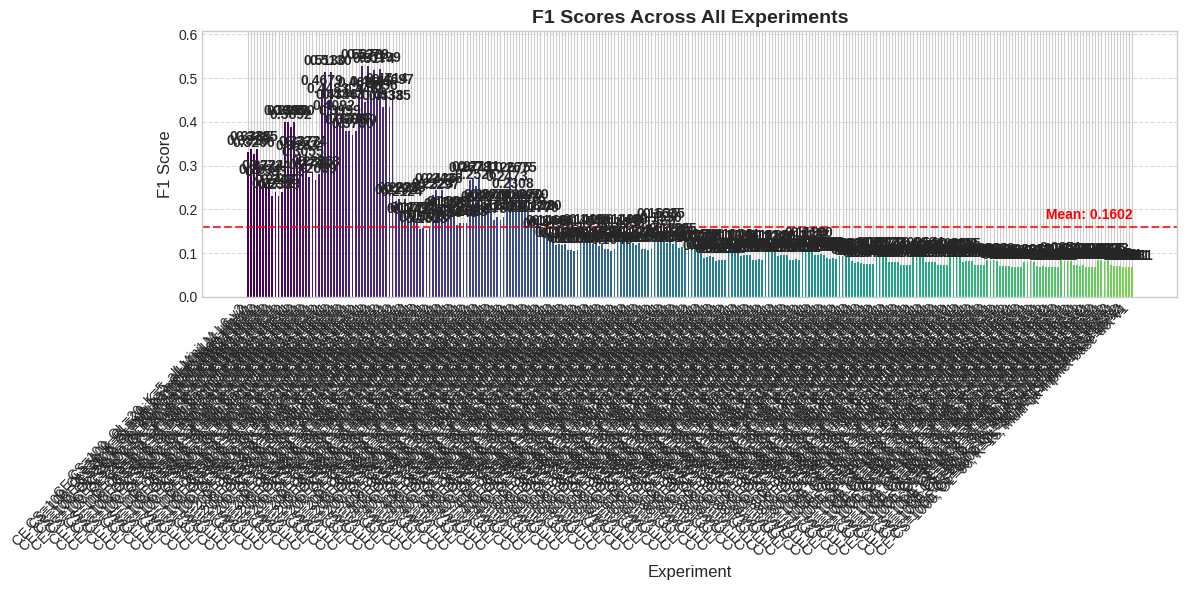

Saved parameter importance plot to visualizations/parameter_importance.png


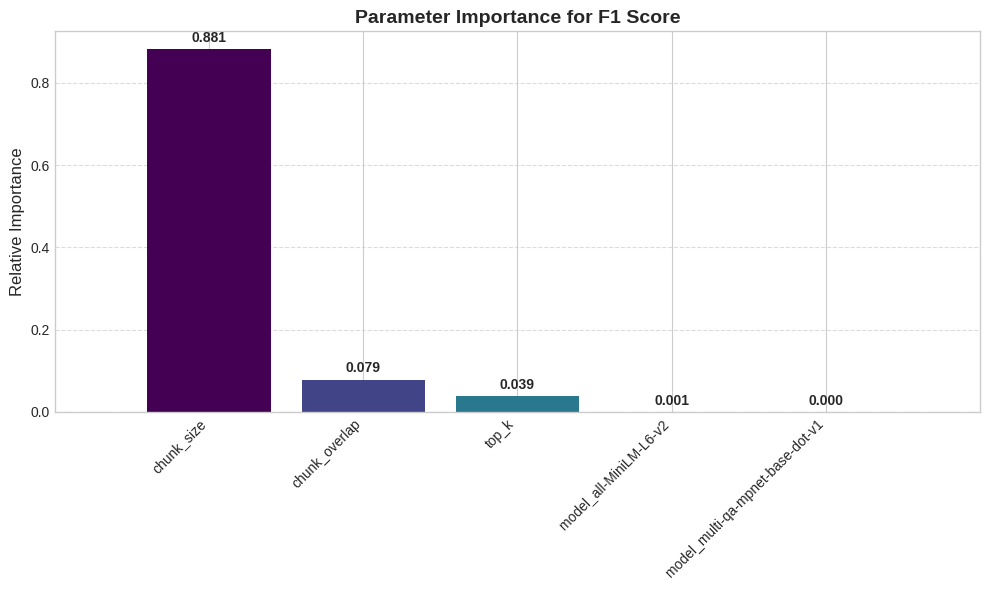

Saved precision-recall tradeoff plot to visualizations/precision_recall_tradeoff.png


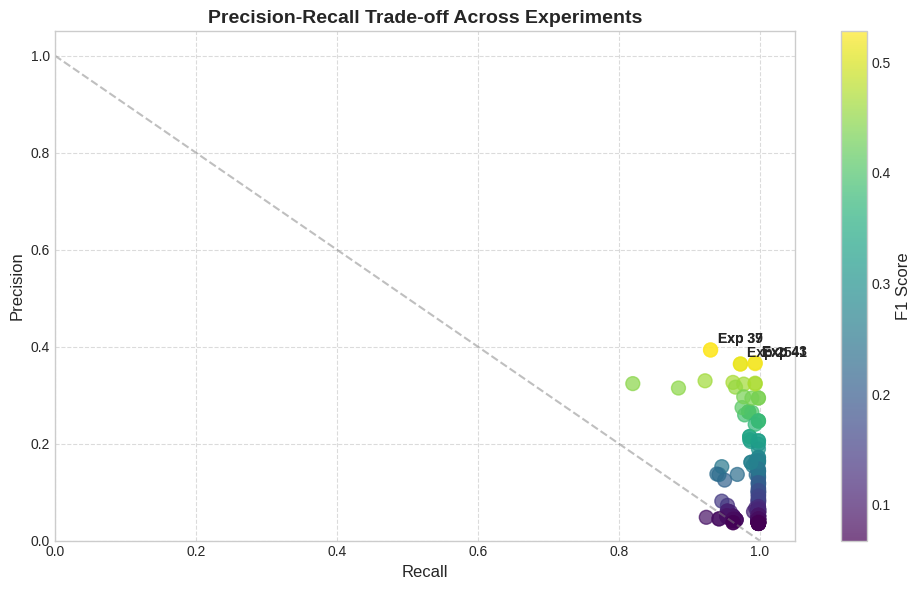

Saved metric comparison chart to visualizations/metric_comparison.png


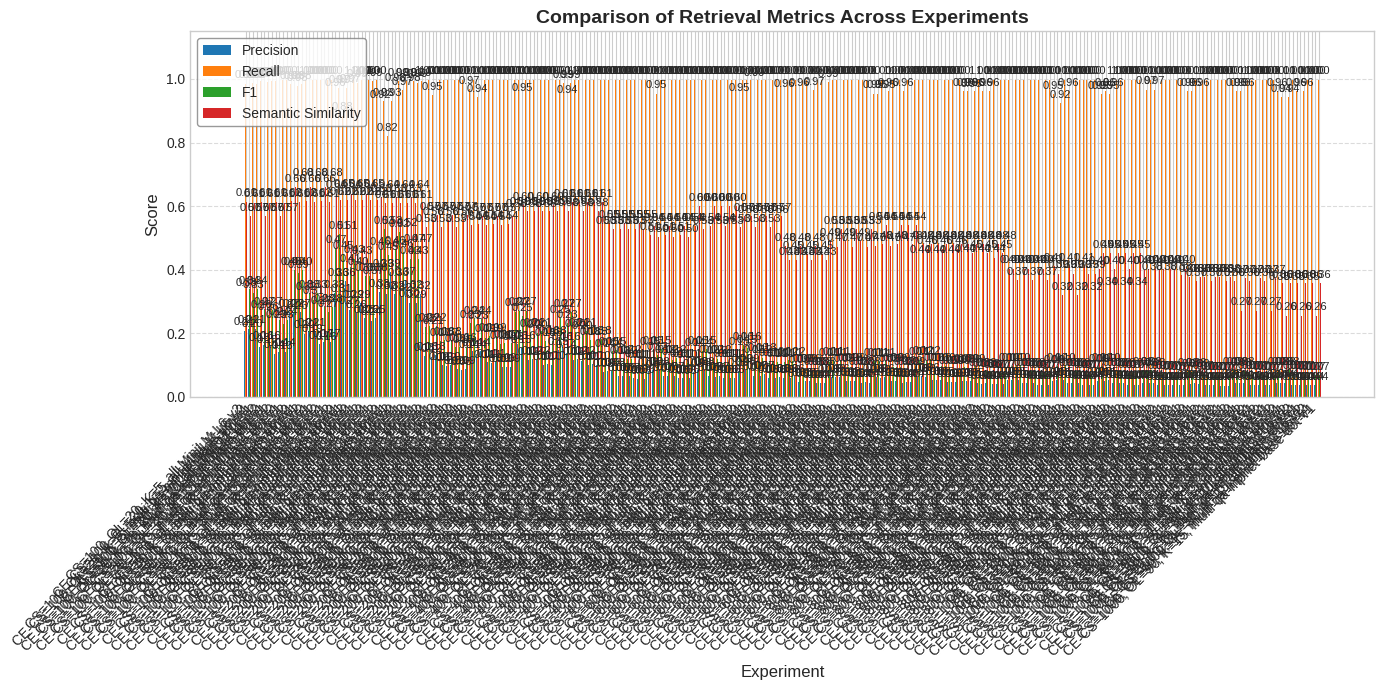


Results summary:
                                       experiment_name  chunk_size  \
0                 CS=100, OL=20, K=5, all-MiniLM-L6-v2         100   
1              CE-CS=100, OL=20, K=5, all-MiniLM-L6-v2         100   
2       CS=100, OL=20, K=5, multi-qa-mpnet-base-dot-v1         100   
3    CE-CS=100, OL=20, K=5, multi-qa-mpnet-base-dot-v1         100   
4                CS=100, OL=20, K=10, all-MiniLM-L6-v2         100   
..                                                 ...         ...   
283  CE-CS=1000, OL=90, K=10, multi-qa-mpnet-base-d...        1000   
284             CS=1000, OL=90, K=15, all-MiniLM-L6-v2        1000   
285          CE-CS=1000, OL=90, K=15, all-MiniLM-L6-v2        1000   
286   CS=1000, OL=90, K=15, multi-qa-mpnet-base-dot-v1        1000   
287  CE-CS=1000, OL=90, K=15, multi-qa-mpnet-base-d...        1000   

     chunk_overlap  top_k                  model_name retriever_type  \
0               20      5            all-MiniLM-L6-v2       standard 

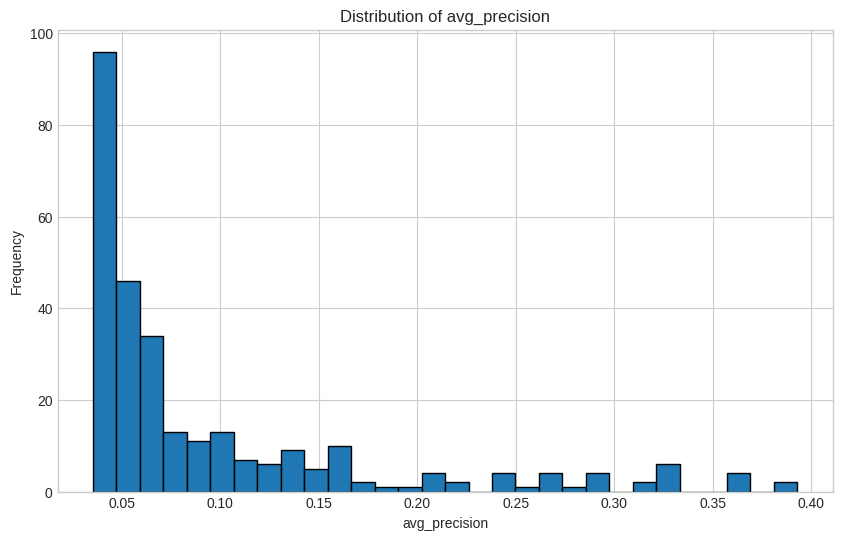

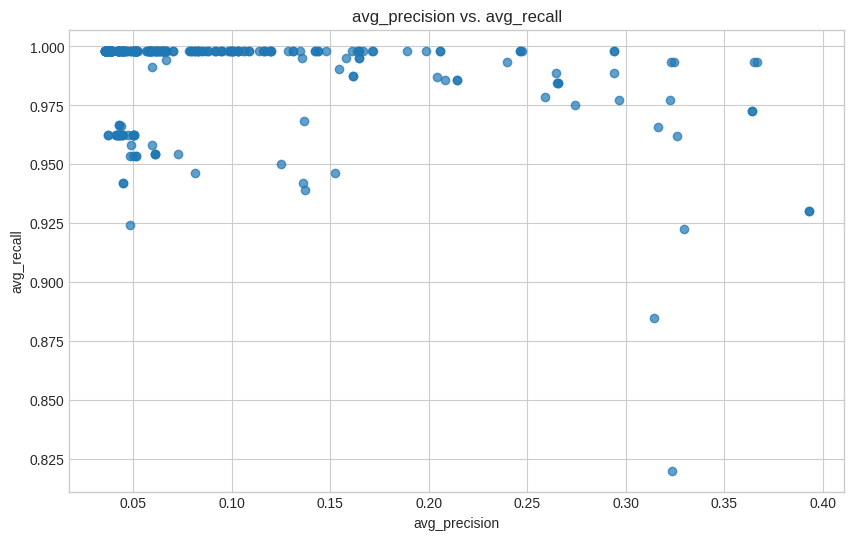

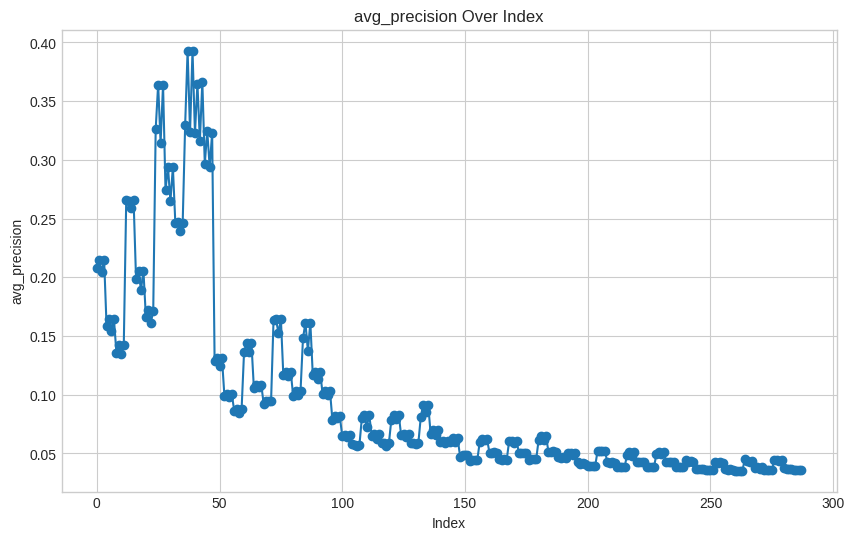

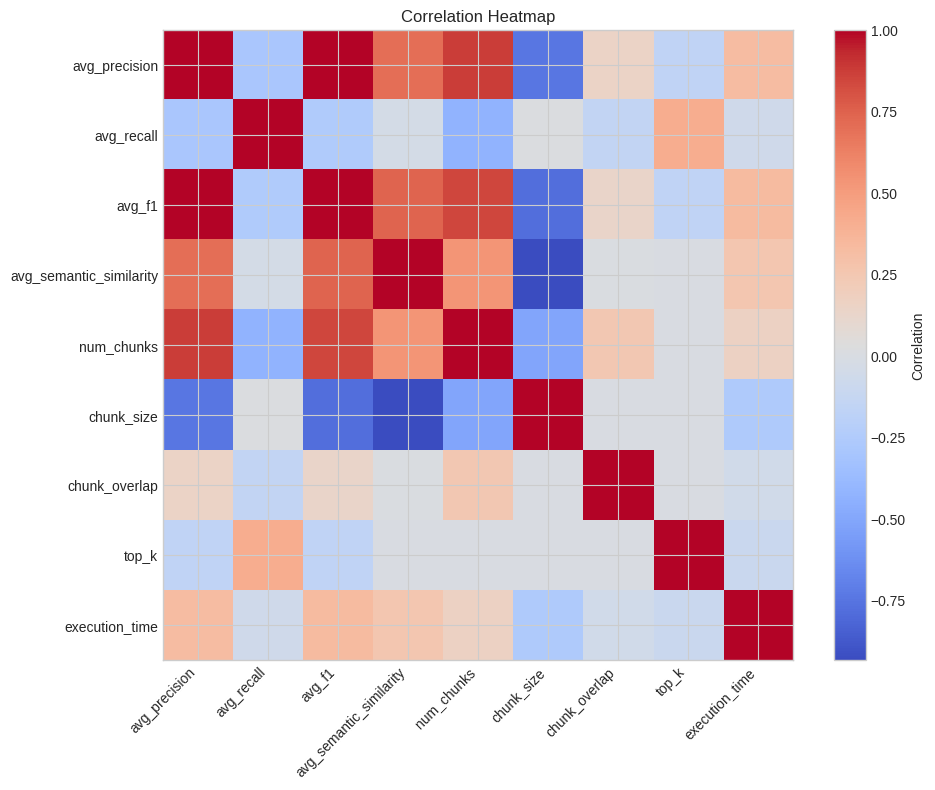

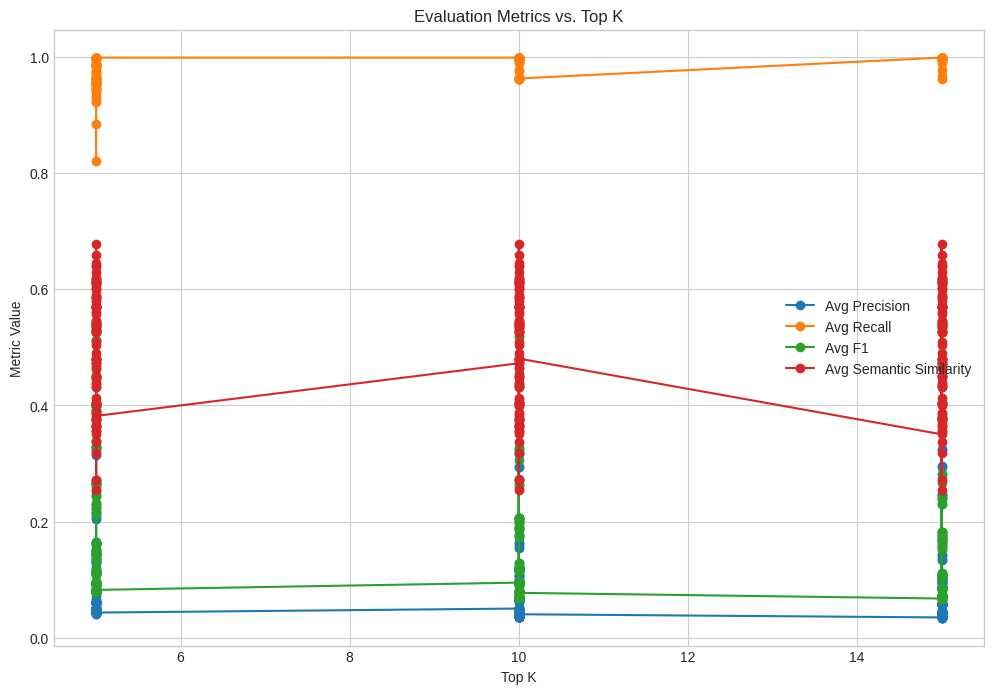

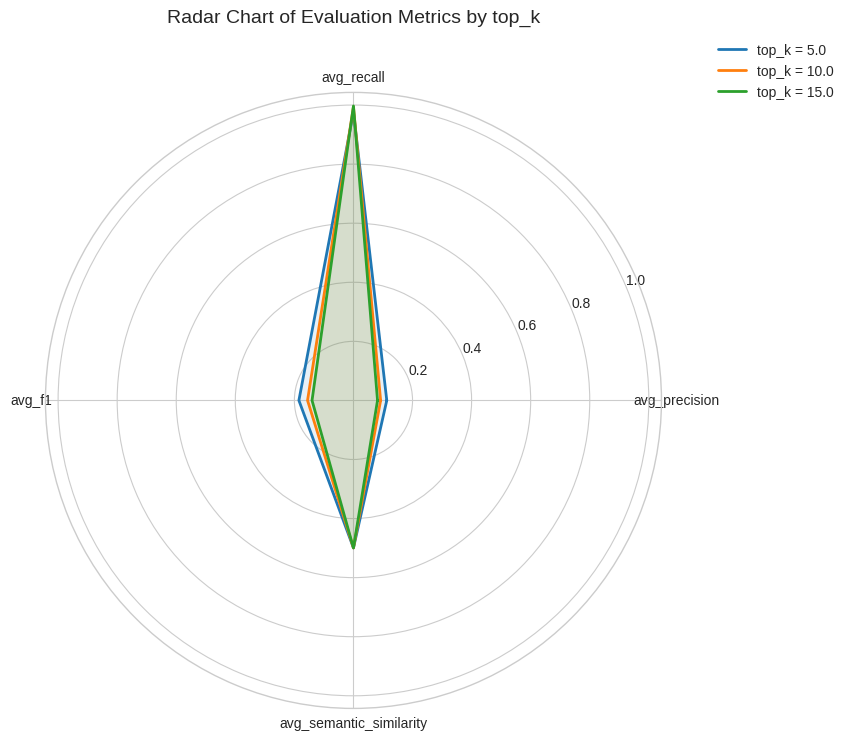

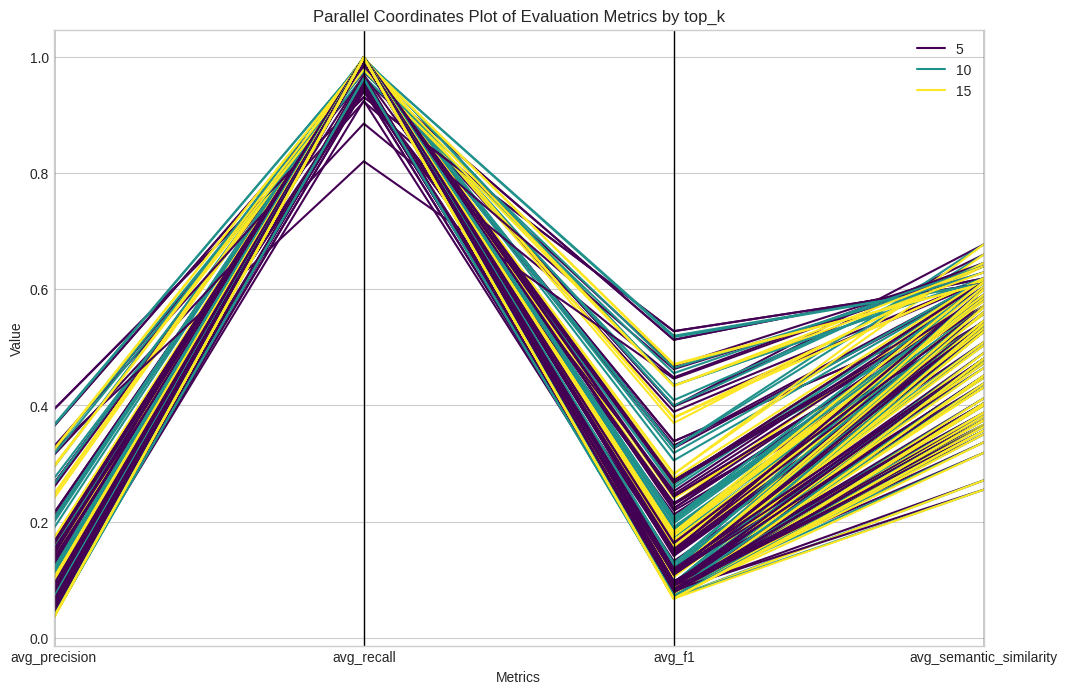

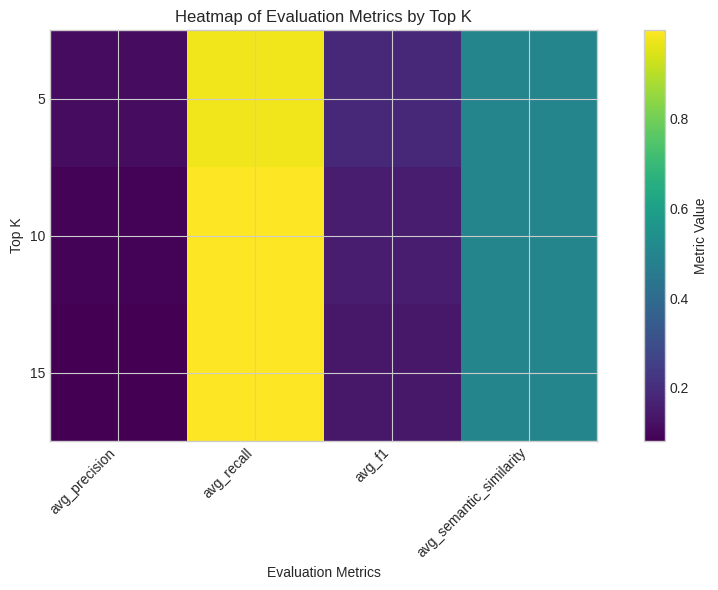


Best experiment by F1 score:
- Experiment: CE-CS=100, OL=90, K=5, all-MiniLM-L6-v2
- Chunk size: 100
- Chunk overlap: 90
- Top K: 5
- Model: all-MiniLM-L6-v2
- Retriever type: cross_encoder
- Precision: 0.3930
- Recall: 0.9303
- F1 Score: 0.5278
- Semantic Similarity: 0.6096
- Execution time: 3.62 seconds

Effect of chunk size:
            avg_precision  avg_recall    avg_f1  avg_semantic_similarity
chunk_size                                                              
100              0.251764    0.980274  0.378566                 0.621200
200              0.117258    0.992664  0.202536                 0.575704
400              0.068814    0.996131  0.125981                 0.545571
600              0.052227    0.991569  0.097633                 0.481172
800              0.043762    0.986118  0.082705                 0.410940
1000             0.038678    0.987815  0.073597                 0.361634

Effect of top_k:
       avg_precision  avg_recall    avg_f1  avg_semantic_similarity

In [16]:
def main():
    """Main function to run the retrieval pipeline."""
    # Download and load a dataset
    dataset_name = "State of the Union"
    print(f"Downloading dataset: {dataset_name}")
    corpus_path, questions_path = download_dataset(dataset_name, "data")
    
    if corpus_path and questions_path:
        print(f"Loading dataset from {corpus_path} and {questions_path}...")
        corpus, questions_df = load_dataset(corpus_path, questions_path, dataset_name)
        print(f"Loaded corpus with {len(corpus)} documents and {len(questions_df)} questions")
        
        # For demonstration, use a smaller subset of questions to speed up execution
        sample_questions_df = questions_df.sample(min(10, len(questions_df)), random_state=42)
        
        # Define parameter grid for grid search
        param_grid = {
            "chunk_size": [100,200, 400,600,800,1000],
            "chunk_overlap": [20, 50,80,90],
            "top_k": [5, 10,15],
            "model_name": ["all-MiniLM-L6-v2", "multi-qa-mpnet-base-dot-v1"],
            "retriever_type": ["standard", "cross_encoder"]
        }
        
        # Run grid search
        results_df, all_results = grid_search_experiments(
            corpus,
            sample_questions_df,
            param_grid,
            results_dir="results",
            visualizations_dir="visualizations",
            show_visualizations=True
        )
        
        # Display the results table
        print("\nResults summary:")
        print(results_df[['experiment_name', 'chunk_size', 'chunk_overlap', 'top_k', 'model_name', 
                         'retriever_type', 'avg_precision', 'avg_recall', 'avg_f1', 
                         'avg_semantic_similarity', 'execution_time']])

        visualize_results(results_df)

        # Find the best experiment by F1 score
        best_exp_idx = results_df['avg_f1'].idxmax()
        best_exp = results_df.loc[best_exp_idx]
        
        print(f"\nBest experiment by F1 score:")
        print(f"- Experiment: {best_exp['experiment_name']}")
        print(f"- Chunk size: {best_exp['chunk_size']}")
        print(f"- Chunk overlap: {best_exp['chunk_overlap']}")
        print(f"- Top K: {best_exp['top_k']}")
        print(f"- Model: {best_exp['model_name']}")
        print(f"- Retriever type: {best_exp['retriever_type']}")
        print(f"- Precision: {best_exp['avg_precision']:.4f}")
        print(f"- Recall: {best_exp['avg_recall']:.4f}")
        print(f"- F1 Score: {best_exp['avg_f1']:.4f}")
        print(f"- Semantic Similarity: {best_exp['avg_semantic_similarity']:.4f}")
        print(f"- Execution time: {best_exp['execution_time']:.2f} seconds")
        
        # Analyze the effect of chunk size
        chunk_size_analysis = results_df.groupby('chunk_size').mean(numeric_only=True)
        print("\nEffect of chunk size:")
        print(chunk_size_analysis[['avg_precision', 'avg_recall', 'avg_f1', 'avg_semantic_similarity']])
        
        # Analyze the effect of top_k
        topk_analysis = results_df.groupby('top_k').mean(numeric_only=True)
        print("\nEffect of top_k:")
        print(topk_analysis[['avg_precision', 'avg_recall', 'avg_f1', 'avg_semantic_similarity']])
        
        # Analyze the effect of model
        model_analysis = results_df.groupby('model_name').mean(numeric_only=True)
        print("\nEffect of model:")
        print(model_analysis[['avg_precision', 'avg_recall', 'avg_f1', 'avg_semantic_similarity']])
        
        # Analyze the effect of retriever type
        if 'retriever_type' in results_df.columns:
            retriever_analysis = results_df.groupby('retriever_type').mean(numeric_only=True)
            print("\nEffect of retriever type:")
            print(retriever_analysis[['avg_precision', 'avg_recall', 'avg_f1', 'avg_semantic_similarity']])
    else:
        print("Failed to download dataset.")

# Disable tqdm progress bars
import tqdm
import functools
tqdm.__init__ = functools.partialmethod(tqdm.__init__, disable=True)
# Replace tqdm with a dummy function that just returns the iterable
def dummy_tqdm(iterable, *args, **kwargs):
    return iterable
tqdm.tqdm = dummy_tqdm

main()